In [23]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from pyramid.arima import auto_arima
from collections import defaultdict
from itertools import product
import pytemperature
import seaborn as sns
print(pm.__version__)

0.7.1


In [8]:
def seasonal_MASE(last_season, this_season, forecast):
    '''
    Parameters
    ----------
    last_season: array containing data for last season (size S)
    
    current_truth: array containing data for current season (size S)
    
    forecast: array containing data predictiing current season (size S)
    '''
    forecast_errors = np.abs(this_season - forecast)
    #print(forecast_errors)
    mean_absolute_forecast_error = np.average(forecast_errors)
    #print('forecast MAE', mean_absolute_forecast_error)
    
    naive = last_season
    naive.index = this_season.index
    naive_errors = np.abs(this_season - naive)
    #print(naive_errors)
    mean_absolute_naive_error = np.average(naive_errors)
    #print('naive MAE', mean_absolute_naive_error)
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

In [9]:
nights =  pd.read_csv('/Users/jinny/Documents/touristcast/exercises/datasets/nights_2010-2017.csv', index_col='date', parse_dates=['date'], 
                        usecols=[*range(1, 15)])
nights.index.freq = 'MS'
temp = pd.read_csv('/Users/jinny/Documents/touristcast/exercises/datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
temp = pytemperature.c2k(temp)
daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/exercises/datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
gdp = pd.read_csv('/Users/jinny/Documents/touristcast/exercises/datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
exog = pd.concat([gdp, temp, daysoff], axis=1)

In [28]:
args = {
    'region': ['CVL', 'IDF', 'NAQ', 'ARA', 'PAC'],
    'with_gdp': [False, True],
    #  'NAQ', 'ARA', 'PAC', 'PDL', 'BRE', 'OCC', 'COR', 'BFC', 'GES', 'HDF', 'NOR'
    # periods is a tuple of (training start year, training end year, test year)
    'periods': [('2010-01-01', f'{end_year}-01-01', f'{end_year + 1}-01-01')
                 for end_year in range(2012, 2015)]
}

sarimax_error_df = pd.DataFrame(columns=list(args.keys()) + ['MAE', 'RMSE', 'Max_error', 'MASE'])

for region, with_gdp, periods in product(*args.values()):
    start_year, end_year, predict_year = periods
    # Input data = nights only, same as testing variable
    input_data = nights[[f'nights_{region}']]
    
    # Exog = everything that's not nights
    exog = pd.concat([temp, daysoff, gdp], axis=1).dropna()
    exog = exog[[f'avgtemp_{region}', f'gdp_{region}', 'daysoff']]
    if not with_gdp:
        exog.drop(f'gdp_{region}', axis=1, inplace=True)

    training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
    testing_period = (input_data.index>=end_year)&(input_data.index<predict_year)

    train_data = input_data[training_period]
    test_data = np.array(input_data[testing_period])
    
    exog_train_data = exog[(exog.index>=start_year)&(exog.index<end_year)]
    exog_future_data = exog[(exog.index>=end_year)&(exog.index<predict_year)]
    
    model = auto_arima(y=np.array(train_data), exogenous=np.array(exog_train_data), 
                       start_p=0, start_q=0, max_p=5, max_q=5, m=12, 
                       seasonal=True, d=1, D=1, trace=False, error_action='ignore', 
                       suppress_warnings=False, stepwise=True)
    
    future_forecast = model.predict(n_periods=12, exogenous=np.array(exog_future_data))
    forecast = pd.DataFrame(future_forecast, columns=[f'nights_{region}'], index=input_data[testing_period].index)

    # --------Calculated error measures for each CV step----------
    rmse_test = np.sqrt(mean_squared_error(test_data, forecast))
    mae_test = mean_absolute_error(test_data, forecast)
    years_train_data = len(train_data.index.strftime('%Y').unique().tolist())

    test = pd.Series(test_data[:,0],
                     index=input_data[testing_period].index)
    forecast.index = input_data[testing_period].index
    
    mase = seasonal_MASE(input_data[str(int(end_year[:4]) - 1)], input_data[end_year[:4]], forecast)
    max_error = np.max(np.abs(forecast[f'nights_{region}'] - test)) / test[forecast[f'nights_{region}'].idxmax(np.abs(forecast[f'nights_{region}'] - test))]
    new_row = {
        'region': region,
        'with_gdp': with_gdp,
        'periods': years_train_data,
        'MAE': mae_test,
        'RMSE': rmse_test,
        'Max_error': max_error,
        'MASE': mase,
    }
    sarimax_error_df = sarimax_error_df.append(new_row, ignore_index=True)


/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

In [29]:
sarimax_error_df.head()

,region,with_gdp,periods,MAE,RMSE,Max_error,MASE
0,CVL,False,2,18.678354,24.058958,0.088551,0.906130
1,CVL,False,3,22.935219,26.573539,0.065172,0.958630
2,CVL,False,4,13.389392,16.027405,0.039579,0.733096
3,CVL,True,2,20636.857226,20636.872771,30.361644,1001.141198
4,CVL,True,3,26.751942,31.806351,0.074023,1.118158


In [32]:
sarimax_error_df.loc[sarimax_error_df.MASE.idxmin()]


region             CVL
with_gdp          True
periods              4
MAE            11.4306
RMSE            13.616
Max_error    0.0321967
MASE          0.625849
Name: 5, dtype: object

In [31]:
sarimax_error_df.loc[sarimax_error_df.MASE.idxmax()]


region           CVL
with_gdp        True
periods            2
MAE          20636.9
RMSE         20636.9
Max_error    30.3616
MASE         1001.14
Name: 3, dtype: object

In [34]:
sarimax_error_df.loc[sarimax_error_df.RMSE.idxmin()]


region             CVL
with_gdp          True
periods              4
MAE            11.4306
RMSE            13.616
Max_error    0.0321967
MASE          0.625849
Name: 5, dtype: object

In [33]:
sarimax_error_df.loc[sarimax_error_df.RMSE.idxmax()]


region           CVL
with_gdp        True
periods            2
MAE          20636.9
RMSE         20636.9
Max_error    30.3616
MASE         1001.14
Name: 3, dtype: object

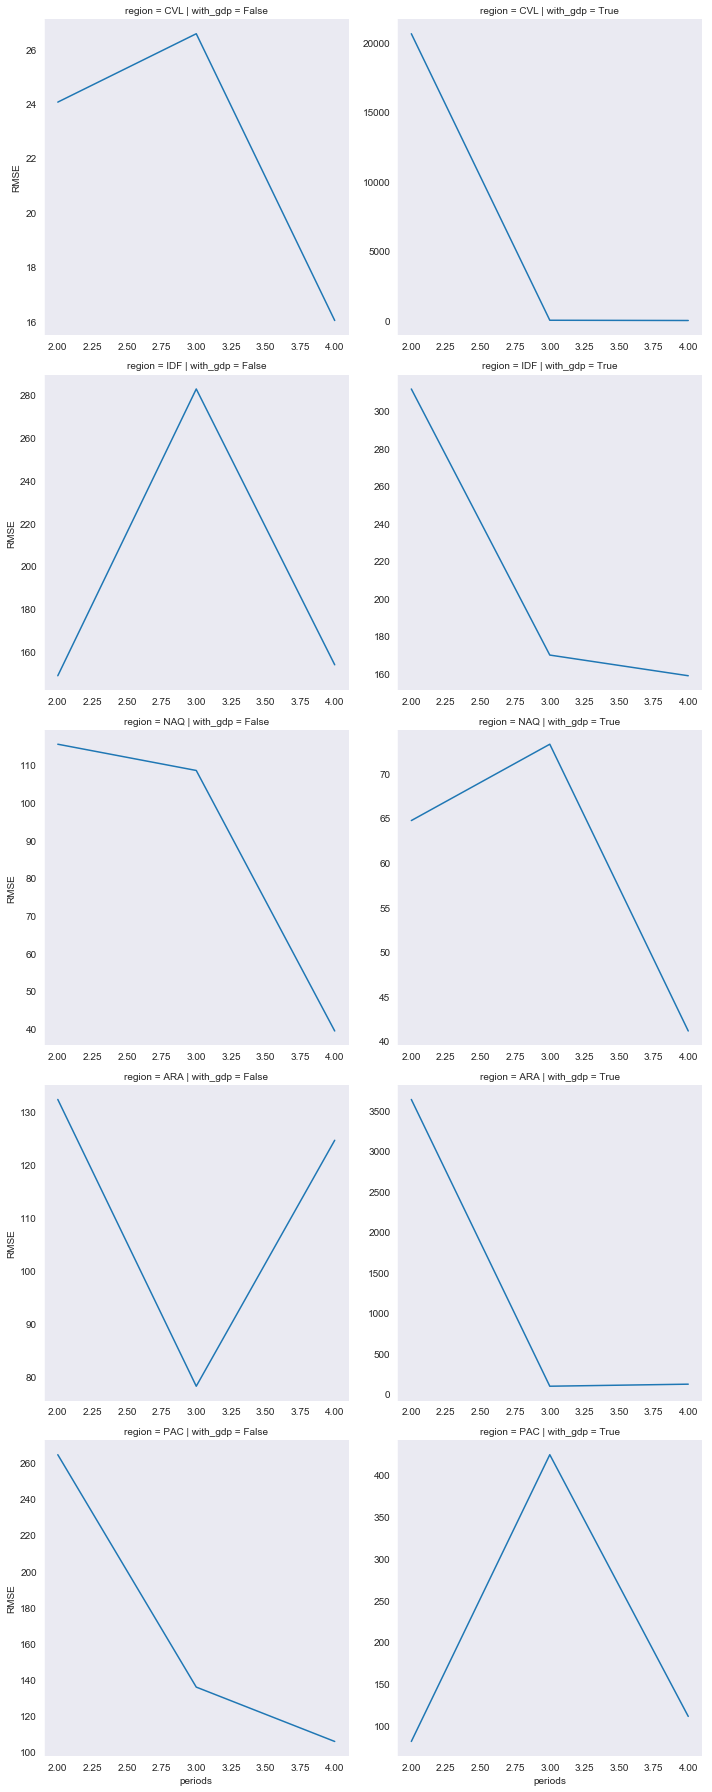

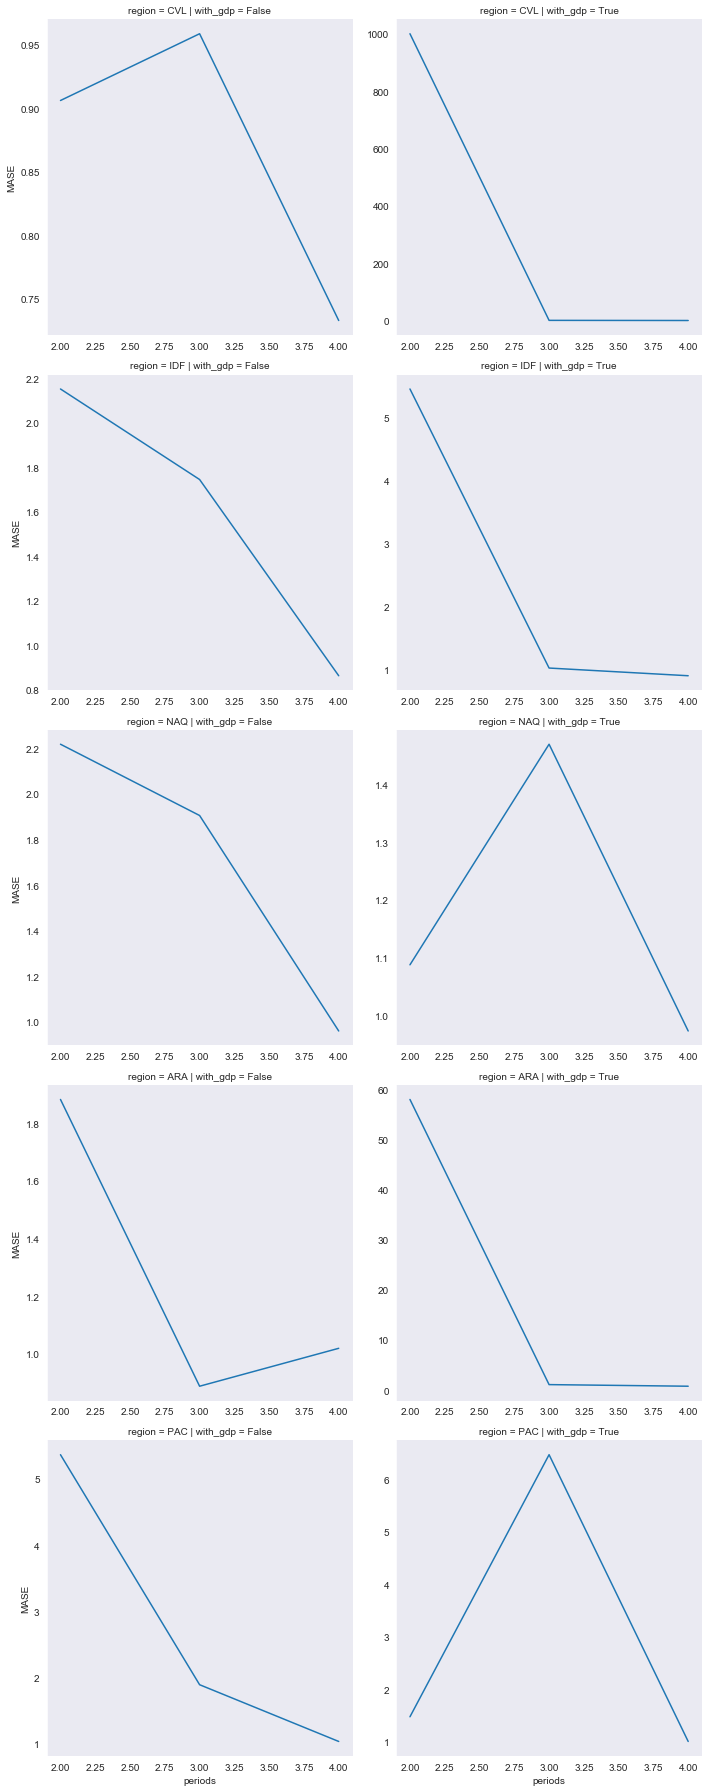

In [36]:
sns.set_style("dark")

sns.relplot(x='periods', y='RMSE',
            row='region',
            col='with_gdp',
            kind='line', legend='full',
            data=sarimax_error_df,
            facet_kws={'sharex': False, 'sharey': False})

sns.relplot(x='periods', y='MASE',
            row='region',
            col='with_gdp',
            kind='line', legend='full',
            data=sarimax_error_df,
            facet_kws={'sharex': False, 'sharey': False});
